In [ ]:
!pip install bertopic

In [2]:
import pandas as pd
import numpy as np
import string
import json
import re

from bertopic import BERTopic
import gensim.corpora as corpora 
from gensim.corpora.dictionary import Dictionary
from sentence_transformers import SentenceTransformer
from gensim.models.coherencemodel import CoherenceModel
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Import Dataset

In [62]:
data = pd.read_json('/content/us_test_data_final_OFFICIAL.jsonl', lines = True)

# Pre-processing

In [63]:
def replace_semicolon(text, threshold=10):
    '''
    Get rid of semicolons.
    First split text into fragments between the semicolons. If the fragment 
    is longer than the threshold, turn the semicolon into a period. O.w treat
    it as a comma.
    Returns new text
    '''
    new_text = ""
    for subset in re.split(';', text):
        subset = subset.strip() # Clear off spaces
        # Check word count
        if len(subset.split()) > threshold:
            # Turn first char into uppercase
            new_text += ". " + subset[0].upper() + subset[1:]
        else:
            # Just append with a comma 
            new_text += ", " + subset

    return new_text

In [64]:
USC_re = re.compile('[Uu]\.*[Ss]\.*[Cc]\.]+')
PAREN_re = re.compile('\([^(]+\ [^\(]+\)')
BAD_PUNCT_RE = re.compile(r'([%s])' % re.escape('"#%&\*\+/<=>@[\]^{|}~_'), re.UNICODE)
BULLET_RE = re.compile('\n[\ \t]*`*\([a-zA-Z0-9]*\)')
DASH_RE = re.compile('--+')
WHITESPACE_RE = re.compile('\s+')
EMPTY_SENT_RE = re.compile('[,\.]\ *[\.,]')
FIX_START_RE = re.compile('^[^A-Za-z]*')
FIX_PERIOD = re.compile('\.([A-Za-z])')
SECTION_HEADER_RE = re.compile('SECTION [0-9]{1,2}\.|\nSEC\.* [0-9]{1,2}\.|Sec\.* [0-9]{1,2}\.')

FIX_PERIOD = re.compile('\.([A-Za-z])')

SECTION_HEADER_RE = re.compile('SECTION [0-9]{1,2}\.|\nSEC\.* [0-9]{1,2}\.|Sec\.* [0-9]{1,2}\.')

In [115]:
def clean_text(text):
    """
    Borrowed from the FNDS text processing with additional logic added in.
    Note: we do not take care of token breaking - assume SPACY's tokenizer
    will handle this for us.
    """

    # Indicate section headers, we need them for features
    text = SECTION_HEADER_RE.sub('SECTION-HEADER', text)
    # For simplicity later, remove '.' from most common acronym
    text = text.replace("U.S.", "US")
    text = text.replace('SEC.', 'Section')
    text = text.replace('Sec.', 'Section')
    text = USC_re.sub('USC', text)

    # Remove parantheticals because they are almost always references to laws 
    # We could add a special tag, but we just remove for now
    # Note we dont get rid of nested parens because that is a complex re
    #text = PAREN_re.sub('LAWREF', text)
    text = PAREN_re.sub('', text)
    
    # Get rid of enums as bullets or ` as bullets
    text = BULLET_RE.sub(' ',text)
    
    # Clean html 
    text = text.replace('&lt;all&gt;', '')

    # Remove annoying punctuation, that's not relevant
    text = BAD_PUNCT_RE.sub('', text)

    # Get rid of long sequences of dashes - these are formating
    text = DASH_RE.sub( ' ', text)

    # removing newlines, tabs, and extra spaces.
    text = WHITESPACE_RE.sub(' ', text)
    
    # If we ended up with "empty" sentences - get rid of them.
    text = EMPTY_SENT_RE.sub('.', text)
    
    # Attempt to create sentences from bullets 
    text = replace_semicolon(text)
    
    # Fix weird period issues + start of text weirdness
    #text = re.sub('\.(?=[A-Z])', '  . ', text)
    # Get rid of anything thats not a word from the start of the text
    text = FIX_START_RE.sub( '', text)
    # Sometimes periods get formatted weird, make sure there is a space between periods and start of sent   
    text = FIX_PERIOD.sub(". \g<1>", text)

    # Fix quotes
    text = text.replace('``', '"')
    text = text.replace('\'\'', '"')

    # Add special punct back in
    text = text.replace('SECTION-HEADER', '')

    # Remove punctuations
    text = re.sub('[,\.!?()]', '', text)

    # Return lowercased sentences
    text = text.lower()

    return text

In [66]:
data['clean_text'] = data.text.map(clean_text)
# data['clean_summary'] = data.summary.map(clean_text)
# data['clean_title'] = data.title.map(clean_text)

selected = pd.DataFrame()
# selected['text'] = data.clean_summary
selected['text'] = data.clean_text

### Stopwords & Lemmatization

In [67]:
def lemmatize_df(corpus):
    tokens = corpus.split(' ')
    stop_words = stopwords.words('english')
    stop_words.extend(['section','shall', 'act', 'secretary', 'subsection', 'year','may', 'state', 'paragraph', 'program', 'short', 'title', 'cite'])
    filtered = [word for word in tokens if word not in stop_words]

    return " ".join(filtered)

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

selected['text'] = selected['text'].apply(lambda x: re.sub("[0-9]", "", x))
selected['clean_text'] = selected['text'].map(lemmatize_df)
selected['clean_text'] = selected['clean_text'].apply(lambda x: " ".join([w.lemma_ for w in nlp(x)]))
selected['clean_text'] = selected['clean_text'].apply(lambda x:  ele for ele in x.split() if len(ele) > 1)

# Baseline BERTopic

In [71]:
model = BERTopic(verbose=True)
topics, probabilities = model.fit_transform(selected['clean_text'])

Batches:   0%|          | 0/103 [00:00<?, ?it/s]

2022-04-03 06:14:27,246 - BERTopic - Transformed documents to Embeddings
2022-04-03 06:14:48,206 - BERTopic - Reduced dimensionality with UMAP
2022-04-03 06:14:48,362 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [72]:
len(model.get_topic_info())

66

In [73]:
len(data)

3269

In [74]:
model.get_topic_info()

,Topic,Count,Name
0,-1,1149,-1_service_health_states_united
1,0,185,0_education_student_school_educational
2,1,120,1_land_area_wilderness_management
3,2,83,2_food_agricultural_agriculture_commodity
4,3,82,3_transportation_motor_vehicle_carrier
...,...,...,...
61,60,12,60_child_placement_parent_adoption
62,61,12,61_child_allotment_income_social
63,62,11,62_inspector_general_investigation_surveillance
64,63,11,63_abortion_woman_pregnancy_health


In [ ]:
def display_topics(model,top_n):
    for i in range(0,top_n):
        print("Topic %d:" % (i), "(%d documents)" %(model.get_topic_freq(i)))
        words = []
        for tup in model.get_topic(i):
            words.append(tup[0])
        print(words)
        print("="*150)
        print()

display_topics(model, 11)

### Coherence Score

In [76]:
cv = model.vectorizer_model
X = cv.fit_transform(selected['clean_text'])
doc_tokens = [text.split(" ") for text in selected['clean_text']]

In [77]:
id2word = corpora.Dictionary(doc_tokens)
texts = doc_tokens
corpus = [id2word.doc2bow(text) for text in texts]

topic_words = []
for i in range(len(model.get_topic_freq())-1):
  interim = []
  interim = [t[0] for t in model.get_topic(i)]
  topic_words.append(interim)

coherence_model = CoherenceModel(topics=topic_words, 
                                 texts=texts, 
                                 corpus=corpus, 
                                 dictionary=id2word, 
                                 coherence='c_v')

baseline_coherence = coherence_model.get_coherence()
baseline_coherence

0.6743329437228555

Unfortunately, BERTopic does not have perplexity and hence will not be able to calculate and compare to the LDA in terms of perplexity score

In [78]:
# log_perplexity = model.log_perplexity(tdf)
# perplexity = 2**(-log_perplexity)
# print('Perplexity: ',perplexity)

### Visualizations

In [79]:
model.visualize_topics()

In [86]:
model.visualize_barchart(topics=[0,1,2,3,4,5,6,7,8,9,10,11])

In [81]:
model.visualize_heatmap()

In [82]:
model.visualize_hierarchy()

In [87]:
model.visualize_term_rank()

# Topic Reduced BERT 

In [93]:
new_topics, new_probs = model.reduce_topics(selected['clean_text'], topics, probabilities, nr_topics="auto")

2022-04-03 06:32:10,199 - BERTopic - Reduced number of topics from 66 to 38


In [94]:
# display_topics(model,20)

In [95]:
model.get_topic_info()

,Topic,Count,Name
0,-1,1149,-1_service_states_health_united
1,0,766,0_united_states_health_provide
2,1,185,1_education_student_school_educational
3,2,120,2_land_area_wilderness_management
4,3,83,3_food_agricultural_agriculture_commodity
5,4,82,4_transportation_motor_vehicle_carrier
6,5,71,5_drug_prescription_pharmacy_substance
7,6,63,6_disaster_emergency_fire_hurricane
8,7,61,7_energy_electric_reliability_efficiency
9,8,60,8_water_project_administrator_river


### Coherence Score of Auto Topic Reduction model

In [96]:
topic_words = []
for i in range(len(model.get_topic_freq())-1):
  interim = []
  interim = [t[0] for t in model.get_topic(i)]
  topic_words.append(interim)

coherence_model = CoherenceModel(topics=topic_words, 
                                 texts=texts, 
                                 corpus=corpus, 
                                 dictionary=id2word, 
                                 coherence='c_v')

reduced_coherence = coherence_model.get_coherence()
reduced_coherence

0.6875477919960549

### Visualizations

In [101]:
model.visualize_topics()

In [103]:
model.visualize_barchart([0,1,2,3,4,5,6,7,8,9,10,11])

In [104]:
model.visualize_heatmap()

In [99]:
model.visualize_hierarchy()

In [100]:
model.visualize_term_rank()

# Embedding

In [105]:
sentence_model = SentenceTransformer("nlpaueb/legal-bert-small-uncased")
embeddings = sentence_model.encode(selected['clean_text'], show_progress_bar=True)

em_model = BERTopic(calculate_probabilities=True, nr_topics="auto")
topics, probabilities = em_model.fit_transform(selected['clean_text'], embeddings)

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/nlpaueb_legal-bert-small-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Batches:   0%|          | 0/103 [00:00<?, ?it/s]

2022-04-03 07:23:36,335 - BERTopic - Reduced dimensionality with UMAP
2022-04-03 07:23:37,083 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-04-03 07:23:44,715 - BERTopic - Reduced number of topics from 57 to 45


In [106]:
em_model.get_topic_info()

,Topic,Count,Name
0,-1,1257,-1_service_states_follow_amend
1,0,654,0_taxable_amount_school_education
2,1,117,1_land_wilderness_water_area
3,2,95,2_commission_member_appoint_appointment
4,3,73,3_motor_vehicle_carrier_product
5,4,61,4_service_carrier_computer_commission
6,5,55,5_security_homeland_transportation_department
7,6,53,6_land_conveyance_county_convey
8,7,47,7_disease_cancer_research_health
9,8,47,8_alien_immigration_nationality_status


In [127]:
em_model.get_topic(9)

[('firearm', 0.0689608731275147),
 ('gun', 0.038560706165773215),
 ('person', 0.03123858029065015),
 ('handgun', 0.030888590700371196),
 ('law', 0.022021415939814534),
 ('license', 0.021861146215602735),
 ('states', 0.020865291128709162),
 ('united', 0.020607464513666747),
 ('attorney', 0.020596711402770376),
 ('offense', 0.02004612321394236)]

In [ ]:
em_model.get_representative_docs(0)

### Coherence Score of Embedded Model

In [107]:
topic_words = []
for i in range(len(em_model.get_topic_freq())-1):
  interim = []
  interim = [t[0] for t in em_model.get_topic(i)]
  topic_words.append(interim)

coherence_model = CoherenceModel(topics=topic_words, 
                                 texts=texts, 
                                 corpus=corpus, 
                                 dictionary=id2word, 
                                 coherence='c_v')

embedded_coherence = coherence_model.get_coherence()
embedded_coherence

0.6737425351243767

## Visualizations

In [108]:
em_model.visualize_topics()

In [128]:
display_topics(em_model, 9)

Topic 0: (654 documents)
['taxable', 'amount', 'school', 'education', 'tax', 'amend', 'insert', 'student', 'credit', 'code']

Topic 1: (117 documents)
['land', 'wilderness', 'water', 'area', 'management', 'river', 'wildlife', 'conservation', 'recreation', 'national']

Topic 2: (95 documents)
['commission', 'member', 'appoint', 'appointment', 'executive', 'chairperson', 'board', 'committee', 'states', 'united']

Topic 3: (73 documents)
['motor', 'vehicle', 'carrier', 'product', 'air', 'safety', 'transportation', 'equipment', 'manufacturer', 'trade']

Topic 4: (61 documents)
['service', 'carrier', 'computer', 'commission', 'broadband', 'video', 'communication', 'internet', 'provider', 'cable']

Topic 5: (55 documents)
['security', 'homeland', 'transportation', 'department', 'information', 'system', 'committee', 'administration', 'report', 'assessment']

Topic 6: (53 documents)
['land', 'conveyance', 'county', 'convey', 'right', 'exchange', 'parcel', 'map', 'foot', 'property']

Topic 7: (

In [109]:
em_model.visualize_hierarchy()

In [129]:
em_model.visualize_barchart([0,1,2,3,4,5,8,9])

In [118]:
em_model.visualize_heatmap()

In [112]:
em_model.visualize_term_rank()

#Comparison of models

In [30]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = BERTopic(verbose=True, nr_topics=num_topics)
        topics, probabilities = model.fit_transform(selected['clean_text'])
        model_list.append(model)

        topic_words = []
        for i in range(len(model.get_topic_freq())-1):
            interim = []
            interim = [t[0] for t in model.get_topic(i)]
            topic_words.append(interim)

        coherencemodel = CoherenceModel(topics=topic_words, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


Batches:   0%|          | 0/103 [00:00<?, ?it/s]

2022-04-03 03:08:13,234 - BERTopic - Transformed documents to Embeddings
2022-04-03 03:08:34,535 - BERTopic - Reduced dimensionality with UMAP
2022-04-03 03:08:34,687 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-04-03 03:08:44,831 - BERTopic - Reduced number of topics from 63 to 3


Batches:   0%|          | 0/103 [00:00<?, ?it/s]

2022-04-03 03:17:31,867 - BERTopic - Transformed documents to Embeddings
2022-04-03 03:17:51,956 - BERTopic - Reduced dimensionality with UMAP
2022-04-03 03:17:52,112 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-04-03 03:18:02,136 - BERTopic - Reduced number of topics from 63 to 9


Batches:   0%|          | 0/103 [00:00<?, ?it/s]

2022-04-03 03:26:40,535 - BERTopic - Transformed documents to Embeddings
2022-04-03 03:27:00,753 - BERTopic - Reduced dimensionality with UMAP
2022-04-03 03:27:00,905 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-04-03 03:27:11,091 - BERTopic - Reduced number of topics from 67 to 15


Batches:   0%|          | 0/103 [00:00<?, ?it/s]

2022-04-03 03:36:06,276 - BERTopic - Transformed documents to Embeddings
2022-04-03 03:36:26,879 - BERTopic - Reduced dimensionality with UMAP
2022-04-03 03:36:27,037 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-04-03 03:36:37,209 - BERTopic - Reduced number of topics from 65 to 21


Batches:   0%|          | 0/103 [00:00<?, ?it/s]

2022-04-03 03:45:22,518 - BERTopic - Transformed documents to Embeddings
2022-04-03 03:45:42,789 - BERTopic - Reduced dimensionality with UMAP
2022-04-03 03:45:42,938 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-04-03 03:45:53,502 - BERTopic - Reduced number of topics from 67 to 27


Batches:   0%|          | 0/103 [00:00<?, ?it/s]

2022-04-03 03:54:40,684 - BERTopic - Transformed documents to Embeddings
2022-04-03 03:55:01,130 - BERTopic - Reduced dimensionality with UMAP
2022-04-03 03:55:01,287 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-04-03 03:55:11,639 - BERTopic - Reduced number of topics from 67 to 33


Batches:   0%|          | 0/103 [00:00<?, ?it/s]

2022-04-03 04:04:08,641 - BERTopic - Transformed documents to Embeddings
2022-04-03 04:04:28,575 - BERTopic - Reduced dimensionality with UMAP
2022-04-03 04:04:28,720 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-04-03 04:04:39,232 - BERTopic - Reduced number of topics from 62 to 39


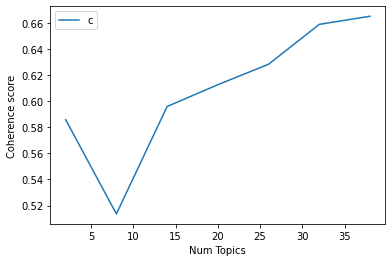

In [33]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=40, step=6)

# Show graph
import matplotlib.pyplot as plt
limit=40; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [39]:
for i in range(len(model_list)):
    print('number of topics:',len(model_list[i].get_topic_info()))
    print('coherence score:',coherence_values[i])

3
0.5859194860288756
9
0.5135627826980542
15
0.5960268879572014
21
0.6127586489177267
27
0.6284780763725315
33
0.6590863198744601
39
0.6653132887670039


In [119]:
print('Baseline BERTopic', baseline_coherence)
print('Automated Reduction BERTopic', reduced_coherence)
print('BERTopic w Legal Embedding', embedded_coherence)

Baseline BERTopic 0.6743329437228555
Automated Reduction BERTopic 0.6875477919960549
BERTopic w Legal Embedding 0.6737425351243767
